In [1]:
import pandas as pd

In [2]:
dir_path = "."

task_list_df = pd.read_csv(f"{dir_path}/3589457371.tsv", sep='\t', header=None, encoding='utf8')
task_list_df

,0,1,2,3,4,5,6,7,8
0,1,NaN,以下の「チェックするページを見る」ボタンを押して課題を実行してください,課題開始はこちらから→,http://18.176.100.68/room/room01?participant_l...,最後の画面で提示されたキーワードを入力後、下のボタンを押してください,NaN,A7K3B,1235760323
1,2,NaN,以下の「チェックするページを見る」ボタンを押して課題を実行してください,課題開始はこちらから→,http://18.176.100.68/room/room01?participant_l...,最後の画面で提示されたキーワードを入力後、下のボタンを押してください,NaN,A7K3B,1235232160
2,3,NaN,以下の「チェックするページを見る」ボタンを押して課題を実行してください,課題開始はこちらから→,http://18.176.100.68/room/room01?participant_l...,最後の画面で提示されたキーワードを入力後、下のボタンを押してください,NaN,A7K3B,1237078326
3,4,NaN,以下の「チェックするページを見る」ボタンを押して課題を実行してください,課題開始はこちらから→,http://18.176.100.68/room/room01?participant_l...,最後の画面で提示されたキーワードを入力後、下のボタンを押してください,NaN,A7K3B,1234011003
4,5,NaN,以下の「チェックするページを見る」ボタンを押して課題を実行してください,課題開始はこちらから→,http://18.176.100.68/room/room01?participant_l...,最後の画面で提示されたキーワードを入力後、下のボタンを押してください,NaN,A7K3B,1234398521
...,...,...,...,...,...,...,...,...,...
95,96,NaN,以下の「チェックするページを見る」ボタンを押して課題を実行してください,課題開始はこちらから→,http://18.176.100.68/room/room01?participant_l...,最後の画面で提示されたキーワードを入力後、下のボタンを押してください,NaN,A7K3B,1233704793
96,97,NaN,以下の「チェックするページを見る」ボタンを押して課題を実行してください,課題開始はこちらから→,http://18.176.100.68/room/room01?participant_l...,最後の画面で提示されたキーワードを入力後、下のボタンを押してください,NaN,A7K3B,1233811808
97,98,NaN,以下の「チェックするページを見る」ボタンを押して課題を実行してください,課題開始はこちらから→,http://18.176.100.68/room/room01?participant_l...,最後の画面で提示されたキーワードを入力後、下のボタンを押してください,NaN,A7K3B,1237404117
98,99,NaN,以下の「チェックするページを見る」ボタンを押して課題を実行してください,課題開始はこちらから→,http://18.176.100.68/room/room01?participant_l...,最後の画面で提示されたキーワードを入力後、下のボタンを押してください,NaN,A7K3B,1236629912


In [3]:
keywords = {
    "A7K3B": "Success",
    "X7R5T": "Ungrouped",
}

task_list_concat_df = pd.DataFrame()
task_list_concat_df['participant.label'] = task_list_df[4].str[-7:]
task_list_concat_df['participant.label'] = task_list_concat_df['participant.label'].str.extract(r'^l=(\d+)$').astype('int')
task_list_concat_df['yahoo_id'] = task_list_df[8]
task_list_concat_df['key_word'] = task_list_df[7]
task_list_concat_df['completion_status'] = task_list_concat_df['key_word'].map(keywords).fillna('Failed')
# task_list_concat_df['completion_status'] = task_list_concat_df['key_word']

print(task_list_concat_df.dtypes)
task_list_concat_df

success_keyword_participant_df = task_list_concat_df[task_list_concat_df['key_word'].map(keywords).notna()]
# success_keyword_participant_df = task_list_concat_df

participant.label     int64
yahoo_id              int64
key_word             object
completion_status    object
dtype: object


In [4]:
pg_df = pd.read_csv(f"{dir_path}/all_apps_wide-2025-08-07.csv")
pg_concat_df = pd.DataFrame()
pg_concat_df['participant.label'] = pg_df['participant.label']
pg_concat_df['participant.payoff'] = pg_df.iloc[:,12]
pg_concat_df['PayPay_exchanged'] = pg_concat_df['participant.payoff'].apply(lambda x: x * 4 + 100)
pg_concat_df['PayPay_ceiled'] = pg_concat_df["PayPay_exchanged"].apply(lambda x: ((x+9) // 10)*10) # ホワイトリストのために1の位切り上げたリスト
pg_concat_df = pg_concat_df.dropna()
pg_concat_df = pg_concat_df.astype('int')
print(pg_concat_df.dtypes)
display(pg_concat_df)

pd.set_option('display.max_columns', None)

display(pg_df.head())
# pg_concat_df.to_csv("payoff_and_partictipantLabel.csv")

participant.label     int64
participant.payoff    int64
PayPay_exchanged      int64
PayPay_ceiled         int64
dtype: object


,participant.label,participant.payoff,PayPay_exchanged,PayPay_ceiled
0,10004,32,228,230
1,10003,12,148,150
2,10005,4,116,120
3,10009,5,120,120
4,10011,44,276,280
...,...,...,...,...
95,10091,14,156,160
96,10031,26,204,210
97,10047,50,300,300
98,10080,0,100,100


,participant.id_in_session,participant.code,participant.label,participant._is_bot,participant._index_in_pages,participant._max_page_index,participant._current_app_name,participant._current_page_name,participant.time_started_utc,participant.visited,participant.mturk_worker_id,participant.mturk_assignment_id,participant.payoff,participant.payoff_preferences_test,participant.payoff_risk_test,participant.payoff_airace,participant.payoff_crd,participant.decision_risk_test,participant.decision_permutation_index_risk_test,participant.result_risk_test,participant.finished,participant.reason_finished,participant.wait_page_arrival,participant.timeout_groups,participant.completion_status,participant.is_selected_PREV,participant.round_selected_PREV,participant.choice_selected_PREV,participant.row_selected_PREV,participant.X1_selected_PREV,participant.X2_selected_PREV,participant.P1_selected_PREV,participant.payment_amount_PREV,participant.is_selected_SOCPREF,participant.round_selected_SOCPREF,participant.choice_selected_SOCPREF,participant.payment_amount_SOCPREF,participant.role_soc_pref,participant.payment_amount_received,participant.payment_amount_given_to_other,participant.expiry,participant.allocations,participant.choice_order,session.code,session.label,session.mturk_HITId,session.mturk_HITGroupId,session.comment,session.is_demo,session.config.target_higher_interval,session.config.ungrouped_link,session.config.timeout_risk_test_seconds,session.config.timeout_final_crd_results_view_seconds,session.config.timeout_results_view_seconds,session.config.information,session.config.timeout_pledge_results_seconds,session.config.timeout_grouping_minutes,session.config.timeout_final_experiment_results_view_seconds,session.config.nb_tasks,session.config.timeout_pay_for_information_result_seconds,session.config.participation_fee,session.config.use_browser_bots,session.config.completion_link,session.config.real_world_currency_per_point,session.config.timeout_redirect_to_prolific,session.config.timeout_lost_focus_minutes,session.config.timeout_grouping_seconds,session.config.timeout_general_instructions_seconds,session.config.endowment,session.config.timeout_final_airace_results_view_seconds,session.config.timeout_pledge_seconds,session.config.timeout_link,session.config.nb_rounds,session.config.timeout_crd_instructions_seconds,session.config.target_lower_interval,session.config.timeout_survey_seconds,session.config.name,session.config.information_cost,session.config.failed_test_link,session.config.timeout_crd_seconds,session.config.timeout_informed_consent_seconds,session.config.group_size,session.config.target,session.config.timeout_airace_instructions_seconds,session.config.round_decision_wait_page_timeout,session.config.opponent_timeout_link,session.config.no_consent_link,session.config.timeout_crd_comprehension_test_seconds,session.config.timeout_airace_comprehension_test_seconds,session.config.kicked_out_link,session.config.uncertainty,session.config.transparency,session.config.timeout_pay_for_information_seconds,session.config.bonus_link,session.config.timeout_decision_link,session.config.show_countdown_seconds,session.config.treatment,session.config.timeout_focus_pledge_seconds,session.config.collective_risk,session.config.timeout_airace_seconds,session.waiting,session.grouped,crd_cost_information_consent.1.player.id_in_group,crd_cost_information_consent.1.player.role,crd_cost_information_consent.1.player.payoff,crd_cost_information_consent.1.player.signed_informed_consent,crd_cost_information_consent.1.player.signed_focus_pledge,crd_cost_information_consent.1.player.prolific_id,crd_cost_information_consent.1.group.id_in_subsession,crd_cost_information_consent.1.subsession.round_number,crd_cost_information_general_instr.1.player.id_in_group,crd_cost_information_general_instr.1.player.role,crd_cost_information_general_instr.1.player.payoff,crd_cost_information_general_instr.1.group.id_in_subsession,crd_cost_information_general_instr.1.subsessi

統合する

In [5]:
marged_df = pd.merge(
    success_keyword_participant_df,
    pg_concat_df,
    on='participant.label',
    how='left'
)

display(marged_df)
marged_df.to_csv("yahooid-payoff.csv")

,participant.label,yahoo_id,key_word,completion_status,participant.payoff,PayPay_exchanged,PayPay_ceiled
0,10001,1235760323,A7K3B,Success,50,300,300
1,10002,1235232160,A7K3B,Success,34,236,240
2,10003,1237078326,A7K3B,Success,12,148,150
3,10004,1234011003,A7K3B,Success,32,228,230
4,10005,1234398521,A7K3B,Success,4,116,120
...,...,...,...,...,...,...,...
81,10096,1233704793,A7K3B,Success,0,100,100
82,10097,1233811808,A7K3B,Success,2,108,110
83,10098,1237404117,A7K3B,Success,4,116,120
84,10099,1236629912,A7K3B,Success,4,119,120


ホワイトリストの作成（下一桁切り上げたもので分類）

In [6]:
import os
import csv
paypay_whitelist_df = marged_df[["yahoo_id", "PayPay_exchanged", "PayPay_ceiled"]]
whitelist_dict = {}
for idx, row in paypay_whitelist_df.iterrows():
    whitelist_dict[row["PayPay_ceiled"]] = []
for idx, row in paypay_whitelist_df.iterrows():
    whitelist_dict[row["PayPay_ceiled"]] += [row["yahoo_id"]]
os.makedirs(f"{dir_path}/whitelists", exist_ok=True)
tmp = set()
for k in whitelist_dict.keys():
    yahooid_list = whitelist_dict[k]
    print(f'{k}: {len(yahooid_list)}')
    with open(f"{dir_path}/whitelists/20250807_{k}pt.txt", 'w') as f:
        writer = csv.writer(f)
        writer.writerow(yahooid_list)

print(sorted(whitelist_dict.keys()))

300: 3
240: 1
150: 3
230: 4
120: 17
220: 5
260: 9
140: 7
280: 1
200: 1
100: 9
180: 3
160: 4
250: 4
170: 2
110: 8
210: 1
130: 3
190: 1
[np.int64(100), np.int64(110), np.int64(120), np.int64(130), np.int64(140), np.int64(150), np.int64(160), np.int64(170), np.int64(180), np.int64(190), np.int64(200), np.int64(210), np.int64(220), np.int64(230), np.int64(240), np.int64(250), np.int64(260), np.int64(280), np.int64(300)]


PayPayポイントのヒストグラム

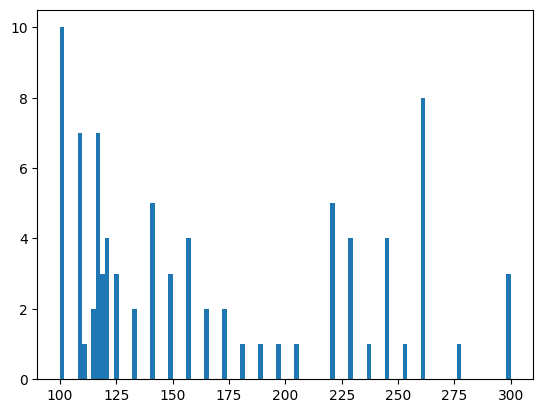

In [7]:
paypay_payoff = marged_df["PayPay_exchanged"].tolist()
paypay_task_num = set(paypay_payoff)
len(paypay_task_num)
import matplotlib.pyplot as plt
plt.hist(paypay_payoff, bins=100)
plt.show()

## 7/24実験結果について

グループわりを見つけ出す

In [8]:
# グループの割り振り
group_set = set(pg_df['crd_cost_information.1.group.id_in_subsession'])
print(group_set)

participant_group = {}
participant_unfullgrouped = {}
for gl in group_set:
    tmp_df = pg_df[pg_df['crd_cost_information.1.group.id_in_subsession'] == gl]
    grouped_label = list(tmp_df['participant.label'])
    if len(grouped_label) != 4:
        participant_unfullgrouped[gl] = grouped_label
    else:
        participant_group[gl] = grouped_label

# グループが割り振られ、4人が集まったグループとその参加者ラベル
print(participant_group)

# グループが割り振られたが、何らかの理由で4人集まらなかったグループとその参加者ラベル
print(participant_unfullgrouped)


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}
{2: [10015, 10014, 10044, 10021], 3: [10034, 10050, 10098, 10090], 4: [10017, 10033, 10061, 10099], 5: [10016, 10060, 10058, 10096], 6: [10005, 10010, 10056, 10087], 7: [10029, 10049, 10042, 10085], 8: [10011, 10037, 10084, 10093], 9: [10028, 10035, 10097, 10022], 10: [10026, 10052, 10071, 10094], 11: [10070, 10072, 10063, 10081], 12: [10055, 10006, 10065, 10054], 13: [10025, 10057, 10046, 10076], 14: [10009, 10075, 10088, 10041], 15: [10020, 10053, 10069, 10082], 16: [10008, 10001, 10045, 10089], 17: [10012, 10013, 10032, 10083], 18: [10023, 10043, 10079, 10048], 19: [10002, 10073, 10019, 10077], 20: [10004, 10040, 10092, 10100], 21: [10003, 10027, 10066, 10051], 22: [10038, 10091, 10031, 10047]}
{1: [10018, 10024, 10036, 10039, 10007, 10059, 10062, 10064, 10068, 10074, 10078, 10067, 10086, 10095], 23: [10080], 24: [10030]}


In [9]:
# 4人グループが作れなかった人たちの原因
unfullgrouped_label = []
for v in participant_unfullgrouped.values():
    unfullgrouped_label += v

ungrouped_label_reason = [pg_df[pg_df['participant.label'] == ul]['participant.reason_finished']  for ul in unfullgrouped_label]
print(ungrouped_label_reason)

[6    あなたは確認問題に5回連続で失敗したので、実験は終了となります。
Name: participant.reason_finished, dtype: object, 14    あなたは確認問題に5回連続で失敗したので、実験は終了となります。
Name: participant.reason_finished, dtype: object, 20    あなたは確認問題に5回連続で失敗したので、実験は終了となります。
Name: participant.reason_finished, dtype: object, 26    あなたは確認問題に5回連続で失敗したので、実験は終了となります。
Name: participant.reason_finished, dtype: object, 32    あなたから制限時間以内に同意を得られなかったため、実験は終了となります。
Name: participant.reason_finished, dtype: object, 36    あなたは確認問題に5回連続で失敗したので、実験は終了となります。
Name: participant.reason_finished, dtype: object, 45    あなたは確認問題に5回連続で失敗したので、実験は終了となります。
Name: participant.reason_finished, dtype: object, 48    あなたは、確認問題を完了するために与えられた時間を超えてしまったため、実験は終了となります。
Name: participant.reason_finished, dtype: object, 53    あなたは確認問題に5回連続で失敗したので、実験は終了となります。
Name: participant.reason_finished, dtype: object, 55    あなたは、説明の文章を読むための最大許容時間を超えてしまったため、実験は終了となります。As...
Name: participant.reason_finished, dtype: object, 58    あなたは確認問題に5回連続で失敗したので、実験は終了となります。
Name: participant.reason_finished, d

確認テストまで成功した人（successもしくはungrouped）

In [10]:
success_label = pg_df[pg_df['participant.completion_status'] == 'success']['participant.label'].tolist()
ungrouped_label = pg_df[pg_df['participant.completion_status'] == 'ungrouped']['participant.label'].tolist()
label = pg_df['participant.label'].tolist()

print(success_label)
print(ungrouped_label)

[10004, 10003, 10005, 10009, 10011, 10017, 10012, 10015, 10014, 10010, 10013, 10008, 10020, 10026, 10016, 10034, 10029, 10025, 10023, 10028, 10033, 10035, 10037, 10032, 10043, 10049, 10027, 10050, 10055, 10053, 10002, 10060, 10056, 10044, 10052, 10006, 10058, 10021, 10057, 10070, 10071, 10072, 10063, 10061, 10069, 10073, 10075, 10001, 10045, 10084, 10040, 10088, 10042, 10094, 10087, 10096, 10041, 10098, 10099, 10089, 10097, 10090, 10081, 10092, 10083, 10022, 10019, 10093, 10077, 10065, 10046, 10082, 10076, 10079, 10100, 10054, 10085, 10048, 10038, 10066, 10051, 10091, 10031, 10047]
[10080, 10030]


寄付した額について

In [11]:
# 寄付した額のカラムリスト
contribute_columns = [f'crd_cost_information.{i}.player.contribution' for i in range(1, 11)]

success_contribution = {}
for sl in success_label:
    row = pg_df[pg_df['participant.label'] == sl][contribute_columns]
    success_contribution[sl] = row.iloc[0].tolist()
print(success_contribution)

{10004: [4, 4, 4, 2, 0, 4, 0, 0, 0, 0], 10003: [4, 4, 4, 4, 4, 4, 4, 2, 4, 4], 10005: [4, 4, 4, 4, 4, 4, 4, 4, 4, 0], 10009: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10011: [0, 0, 2, 0, 2, 0, 0, 0, 2, 0], 10017: [2, 2, 0, 0, 0, 0, 0, 0, 0, 0], 10012: [2, 2, 4, 4, 0, 2, 2, 0, 0, 0], 10015: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4], 10014: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4], 10010: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4], 10013: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10008: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10020: [0, 0, 2, 2, 0, 2, 0, 0, 0, 0], 10026: [2, 2, 4, 0, 0, 4, 2, 0, 0, 0], 10016: [4, 4, 4, 4, 4, 0, 0, 0, 0, 0], 10034: [0, 2, 4, 2, 0, 4, 2, 2, 0, 2], 10029: [4, 4, 4, 4, 0, 0, 0, 0, 0, 0], 10025: [2, 4, 4, 4, 4, 4, 4, 0, 0, 0], 10023: [4, 2, 2, 2, 2, 0, 0, 2, 0, 0], 10028: [4, 4, 2, 4, 4, 4, 4, 4, 4, 4], 10033: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10035: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 10037: [2, 4, 4, 4, 4, 2, 2, 2, 2, 2], 10032: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10043: [4, 4, 0, 0, 0, 2, 0, 0, 0, 0], 10049: [2, 2, 2, 2, 0, 2

各グループと寄付額について

In [12]:
round_column = [f"Round {i}" for i in range(1, 11)]

dfs = {}
for g, labels in participant_group.items():
    part_contrib = []
    part_index = []
    for l in labels:
        try:
            part_contrib.append(success_contribution[l])
            part_index.append(l)
        except KeyError as e:
            print(f"{l}のキーが存在しません。（success_contributionに含まれていない->success_labelにいない->途中離脱？）")
    # print(part_contrib)
    df = pd.DataFrame(part_contrib, columns=round_column, index=part_index)
    dfs[g] = df
    # display(df)

各グループの目標額を探し出す

In [13]:
# ちゃんと4人集まったグループに限定する
group_target = {}
for g in participant_group.keys():
    group_target[g] = pg_df[pg_df['crd_cost_information.1.group.id_in_subsession'] == g]['crd_cost_information.1.group.target'].iloc[0]

print(group_target)

{2: np.int64(160), 3: np.int64(20), 4: np.int64(60), 5: np.int64(20), 6: np.int64(140), 7: np.int64(160), 8: np.int64(80), 9: np.int64(20), 10: np.int64(160), 11: np.int64(120), 12: np.int64(0), 13: np.int64(120), 14: np.int64(120), 15: np.int64(100), 16: np.int64(0), 17: np.int64(0), 18: np.int64(20), 19: np.int64(100), 20: np.int64(20), 21: np.int64(100), 22: np.int64(40)}


グラフ描画：累積貢献額（積み上げグラフ）

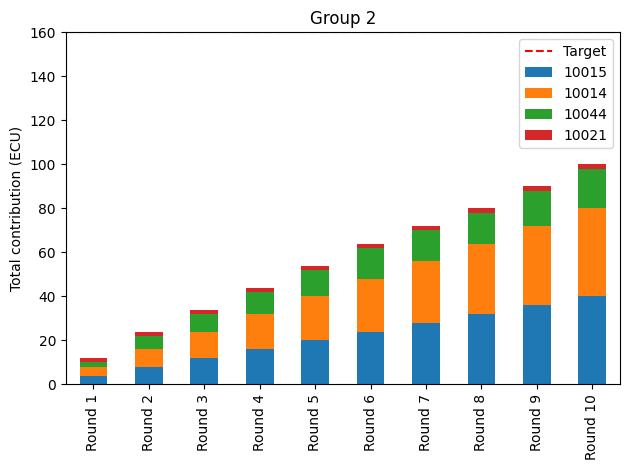

In [14]:
import matplotlib.pyplot as plt
import os
"""
縦軸は累計貢献額、横軸がラウンド数
1.貢献額は積み立て式にする
2.そのグループの目標額を示す
"""
def TotalContribution(groups: list):
    os.makedirs(f"{dir_path}/total_contribution", exist_ok=True)
    for g in groups:
        df = dfs[g].cumsum(axis=1)
        df = df.T
        ax = df.plot(kind='bar', stacked=True)
        plt.axhline(y=group_target[g], color='red', linestyle='--', label='Target')
        plt.title(f"Group {g}")
        plt.ylim(0, 160)
        plt.ylabel("Total contribution (ECU)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{dir_path}/total_contribution/Group_{g}.png")
        plt.show()
        break

TotalContribution(participant_group.keys())

グラフ描画：１ラウンドあたりの寄付額（折れ線グラフ）

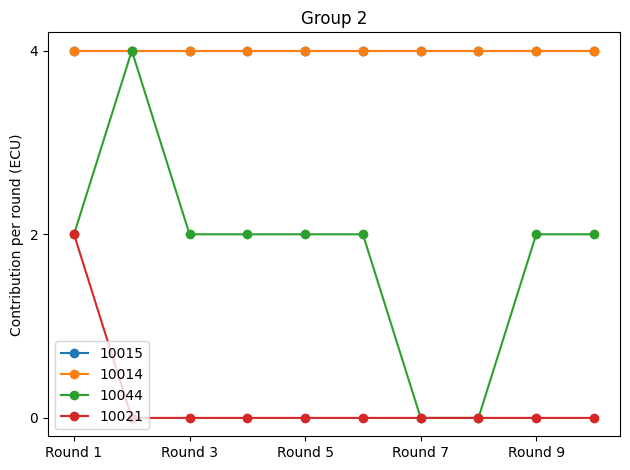

In [15]:
import os
def ContributionPerRound(groups: list):
    os.makedirs(f"{dir_path}/contribution_per_round", exist_ok=True)
    for g in groups:
        df = dfs[g]
        df = df.T
        ax = df.plot(kind='line', marker='o')
        plt.title(f"Group {g}")
        ax.set_yticks([0, 2, 4])
        plt.ylabel("Contribution per round (ECU)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{dir_path}/contribution_per_round/Group_{g}")
        plt.show()
        break

ContributionPerRound(participant_group.keys())

目標達成したグループ、そうでないグループ

In [16]:
target_success_group = []
target_failed_group = []

for g in participant_group.keys():
    group_mem = pg_df[pg_df['crd_cost_information.1.group.id_in_subsession'] == g].iloc[0]
    if group_mem['crd_cost_information.10.group.failed'] == 0:
        target_success_group.append(g)
    else:
        target_failed_group.append(g)

print(target_success_group, target_failed_group)

[3, 5, 6, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22] [2, 4, 7, 10, 14, 15]


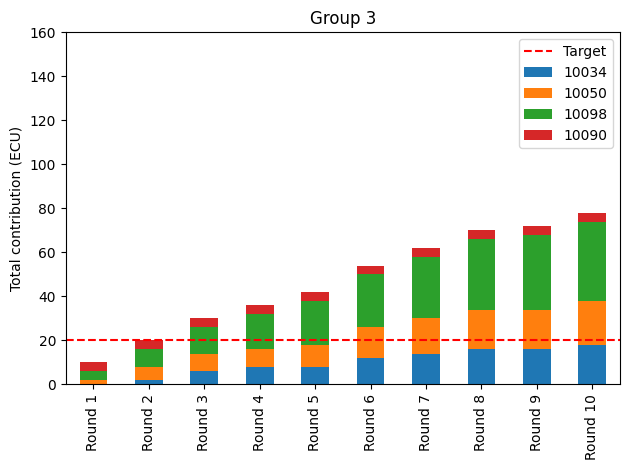

In [17]:
TotalContribution(target_success_group)

各グループの参加者の提案額

In [18]:
# dictに,labelをkeyとして、valueには[group, round1_pledge, round6_pledge]とする
participant_pledges = {}
for g in participant_group.keys():
    # 1ラウンドと6ラウンドの提案額
    pledges_df = pg_df[pg_df['crd_cost_information.1.group.id_in_subsession'] == g][['participant.label','crd_cost_information.1.player.pledge', 'crd_cost_information.6.player.pledge']]

    for index, row in pledges_df.iterrows():
        participant_pledges[int(row['participant.label'])] = [g, row['crd_cost_information.1.player.pledge'], row['crd_cost_information.6.player.pledge']]
    
print(participant_pledges)

{10015: [2, np.float64(160.0), np.float64(160.0)], 10014: [2, np.float64(160.0), np.float64(160.0)], 10044: [2, np.float64(50.0), np.float64(59.0)], 10021: [2, np.float64(20.0), np.float64(50.0)], 10034: [3, np.float64(80.0), np.float64(80.0)], 10050: [3, np.float64(50.0), np.float64(30.0)], 10098: [3, np.float64(20.0), np.float64(40.0)], 10090: [3, np.float64(20.0), np.float64(80.0)], 10017: [4, np.float64(160.0), np.float64(160.0)], 10033: [4, np.float64(0.0), np.float64(0.0)], 10061: [4, np.float64(50.0), np.float64(50.0)], 10099: [4, np.float64(20.0), np.float64(20.0)], 10016: [5, np.float64(100.0), np.float64(20.0)], 10060: [5, np.float64(0.0), np.float64(20.0)], 10058: [5, np.float64(20.0), np.float64(100.0)], 10096: [5, np.float64(160.0), np.float64(160.0)], 10005: [6, np.float64(160.0), np.float64(160.0)], 10010: [6, np.float64(160.0), np.float64(160.0)], 10056: [6, np.float64(20.0), np.float64(140.0)], 10087: [6, np.float64(5.0), np.float64(160.0)], 10029: [7, np.float64(160.0

グラフ描画：提案額も盛り込んだグラフ

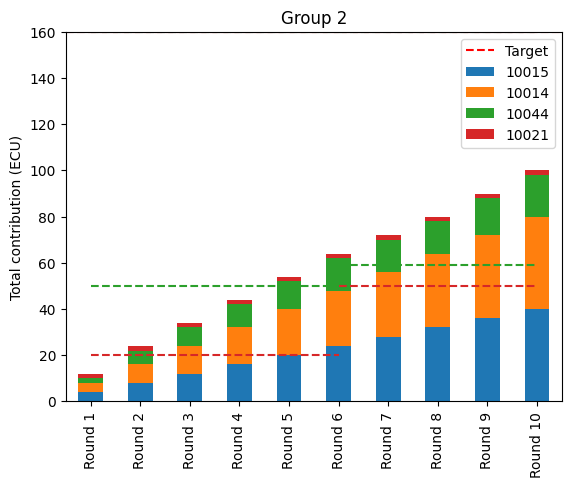

In [19]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for g, labels in participant_group.items():
    df = dfs[g].cumsum(axis=1)
    df = df.T
    ax = df.plot(kind='bar', stacked=True)
    plt.axhline(y=group_target[g], color='red', linestyle='--', label='Target')
    plt.legend()
    # 各参加者の提案額を加える
    for i, l in enumerate(labels):
        r1_pledge = participant_pledges[l][1]
        r6_pledge = participant_pledges[l][2]
        plt.plot([0, 5], [r1_pledge, r1_pledge], color=colors[i], linestyle='--', label=f'{l}_predges')
        plt.plot([5, 9], [r6_pledge, r6_pledge], color=colors[i], linestyle='--', label=f'{l}_predges')
    plt.title(f"Group {g}")
    plt.ylim(0, 160)
    plt.ylabel("Total contribution (ECU)")
    # plt.legend()
    plt.show()
    break

ブラックリストの作成

In [20]:
blacklist = task_list_df[8].tolist()
print(blacklist)
import csv
with open(f"{dir_path}/blacklist.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(blacklist)

[1235760323, 1235232160, 1237078326, 1234011003, 1234398521, 1233449113, 1234134196, 1236211733, 1235414834, 1236962682, 1232967173, 1237771326, 1233898505, 1232550322, 1224944955, 1233693883, 1233725127, 1227956884, 1234661974, 1232670859, 1232944809, 1232000614, 1233440454, 1229307331, 1229479352, 1230123043, 1234197981, 1237913367, 1236230049, 1238653743, 1237792425, 1228610714, 1229623487, 1238949204, 1228484420, 1233790207, 1224934942, 1237957843, 1230241438, 1235490203, 1224938299, 1234359492, 1230757608, 1224940519, 1234664424, 1232607180, 1232159264, 1225777013, 1232689511, 1231631796, 1236380543, 1236807094, 1230061334, 1237700957, 1239210236, 1237273534, 1237662494, 1230924539, 1233108386, 1231920741, 1233523621, 1236653786, 1225809034, 1237384681, 1232136291, 1229752932, 1239876053, 1226191757, 1232657212, 1234965726, 1237146426, 1239940468, 1234136495, 1230673403, 1226927602, 1238712311, 1232629628, 1227004012, 1232726676, 1231198994, 1235801874, 1231289086, 1231416143, 123

9/3

成功率

貢献額0の人：5
貢献額0の人：17
[Uncertainty] DataLoader : all_apps_wide-2025-07-24.csv
[Uncertainty + Info] DataLoader : all_apps_wide-2025-08-07.csv


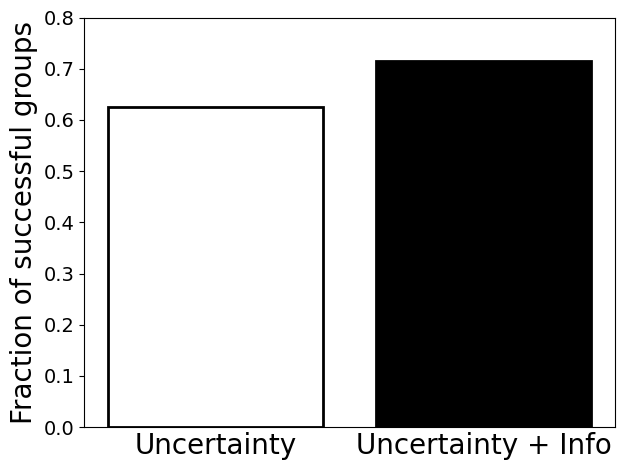

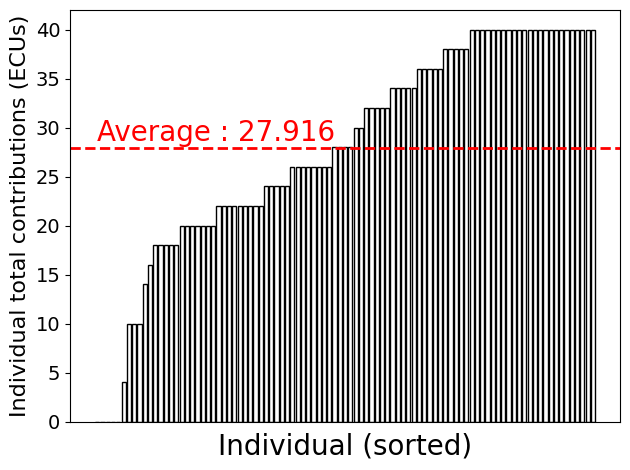

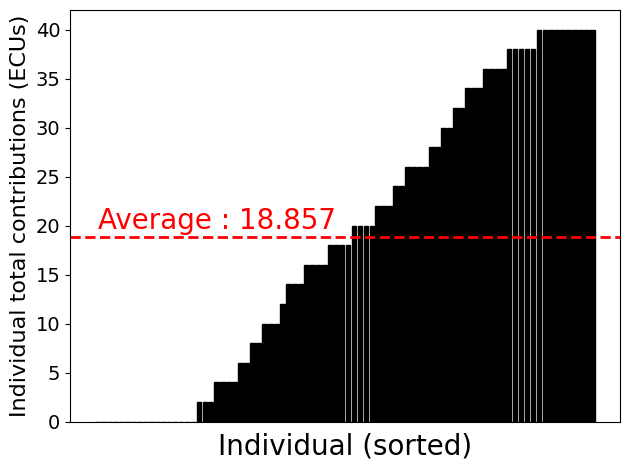

[10022, 10024, 10054, 10035, 10085, 10062, 10091, 10004, 10031, 10100, 10087, 10005, 10071, 10026, 10037, 10025, 10033, 10013, 10012, 10041, 10047, 10036, 10059, 10068, 10016, 10027, 10014, 10019, 10095, 10038, 10070, 10074, 10094, 10076, 10001, 10067, 10064, 10023, 10034, 10077, 10006, 10045, 10030, 10075, 10058, 10082, 10060, 10042, 10097, 10066, 10048, 10089, 10073, 10084, 10017, 10052, 10050, 10090, 10015, 10007, 10061, 10049, 10053, 10078, 10051, 10032, 10055, 10044, 10029, 10056, 10065, 10020, 10040, 10093, 10008, 10021, 10039, 10081, 10072, 10092, 10018, 10002, 10057, 10046, 10083, 10028, 10069, 10080, 10096, 10079, 10010, 10011, 10063, 10043, 10099, 10009, 10003, 10086, 10098, 10088]
{10022: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4], 10024: [2, 4, 0, 2, 4, 0, 2, 4, 2, 4], 10054: [2, 4, 2, 4, 2, 2, 4, 2, 2, 4], 10035: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4], 10085: [4, 2, 4, 4, 4, 4, 4, 4, 4, 4], 10062: [2, 4, 2, 2, 2, 2, 2, 2, 2, 2], 10091: [2, 2, 2, 2, 2, 4, 2, 2, 2, 2], 10004: [4, 2, 2, 2, 2, 2,

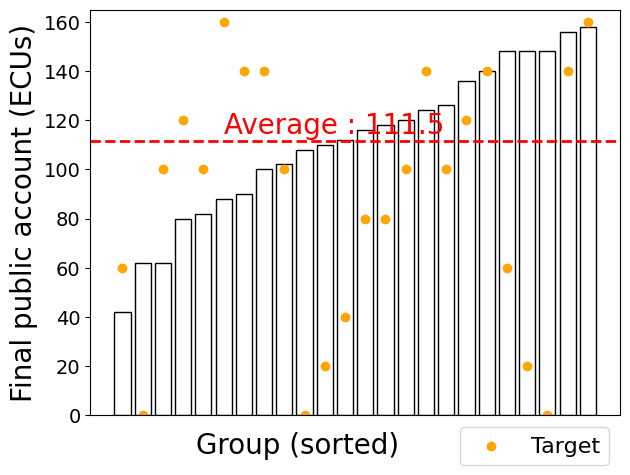

[10004, 10003, 10005, 10009, 10011, 10017, 10018, 10012, 10015, 10014, 10010, 10013, 10008, 10020, 10024, 10026, 10016, 10034, 10029, 10025, 10036, 10023, 10028, 10033, 10035, 10037, 10039, 10032, 10043, 10049, 10027, 10050, 10007, 10055, 10053, 10002, 10059, 10060, 10056, 10044, 10052, 10006, 10058, 10021, 10057, 10062, 10070, 10071, 10064, 10072, 10063, 10061, 10069, 10068, 10073, 10074, 10075, 10001, 10078, 10067, 10045, 10084, 10040, 10088, 10042, 10094, 10086, 10087, 10096, 10041, 10095, 10098, 10099, 10089, 10097, 10090, 10081, 10092, 10083, 10022, 10019, 10093, 10077, 10065, 10046, 10082, 10076, 10079, 10100, 10054, 10085, 10048, 10038, 10066, 10051, 10091, 10031, 10047, 10080, 10030]
{10004: [4, 4, 4, 2, 0, 4, 0, 0, 0, 0], 10003: [4, 4, 4, 4, 4, 4, 4, 2, 4, 4], 10005: [4, 4, 4, 4, 4, 4, 4, 4, 4, 0], 10009: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10011: [0, 0, 2, 0, 2, 0, 0, 0, 2, 0], 10017: [2, 2, 0, 0, 0, 0, 0, 0, 0, 0], 10018: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 10012: [2, 2, 4

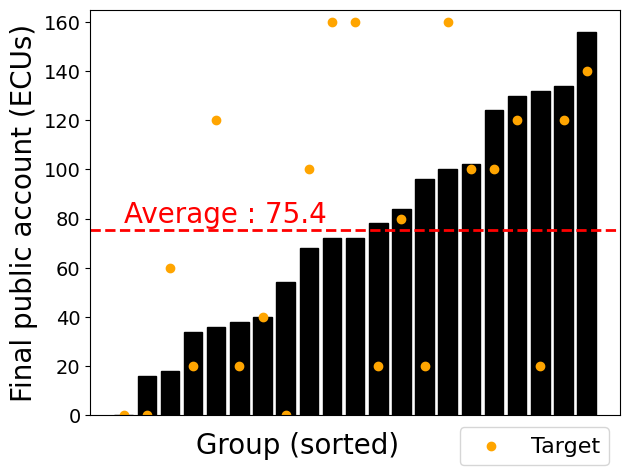

In [21]:
from getdata import *

# oTreeから得られた実験データ
g_normal = GetData(
    dirpath="./",
    filename="all_apps_wide-2025-07-24.csv"
)
g_info = GetData(
    dirpath="./",
    filename="all_apps_wide-2025-08-07.csv"
)

# 貢献額が0の人数
def zero_contrib(d):
    contribs = [sum(v) for v in d.values()]
    cnt = 0
    for c in contribs:
        if c == 0:
            cnt += 1
    print(f"貢献額0の人：{cnt}")
zero_contrib(g_normal.get_success_contribution())
zero_contrib(g_info.get_success_contribution())

# グラフ描画用のインスタンス
gp = GraphPlot(g_normal, savefig=False, debug=True, figtype="png")
gp_info = GraphPlot(g_info, savefig=False, debug=True, figtype="png")
gp.plot_success_percentage_ver2(g_info)
gp.plot_individual_contrib()
gp_info.plot_individual_contrib(bartype="black")
gp.plot_group_contrib()
gp_info.plot_group_contrib(bartype="black")

9/10

分析

[10022, 10024, 10054, 10035, 10085, 10062, 10091, 10004, 10031, 10100, 10087, 10005, 10071, 10026, 10037, 10025, 10033, 10013, 10012, 10041, 10047, 10036, 10059, 10068, 10016, 10027, 10014, 10019, 10095, 10038, 10070, 10074, 10094, 10076, 10001, 10067, 10064, 10023, 10034, 10077, 10006, 10045, 10030, 10075, 10058, 10082, 10060, 10042, 10097, 10066, 10048, 10089, 10073, 10084, 10017, 10052, 10050, 10090, 10015, 10007, 10061, 10049, 10053, 10078, 10051, 10032, 10055, 10044, 10029, 10056, 10065, 10020, 10040, 10093, 10008, 10021, 10039, 10081, 10072, 10092, 10018, 10002, 10057, 10046, 10083, 10028, 10069, 10080, 10096, 10079, 10010, 10011, 10063, 10043, 10099, 10009, 10003, 10086, 10098, 10088]
[10004, 10003, 10005, 10009, 10011, 10017, 10018, 10012, 10015, 10014, 10010, 10013, 10008, 10020, 10024, 10026, 10016, 10034, 10029, 10025, 10036, 10023, 10028, 10033, 10035, 10037, 10039, 10032, 10043, 10049, 10027, 10050, 10007, 10055, 10053, 10002, 10059, 10060, 10056, 10044, 10052, 10006, 1005

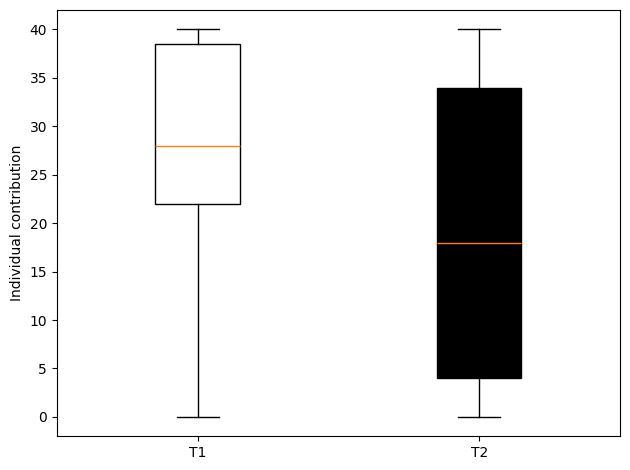

[10022, 10024, 10054, 10035, 10085, 10062, 10091, 10004, 10031, 10100, 10087, 10005, 10071, 10026, 10037, 10025, 10033, 10013, 10012, 10041, 10047, 10036, 10059, 10068, 10016, 10027, 10014, 10019, 10095, 10038, 10070, 10074, 10094, 10076, 10001, 10067, 10064, 10023, 10034, 10077, 10006, 10045, 10030, 10075, 10058, 10082, 10060, 10042, 10097, 10066, 10048, 10089, 10073, 10084, 10017, 10052, 10050, 10090, 10015, 10007, 10061, 10049, 10053, 10078, 10051, 10032, 10055, 10044, 10029, 10056, 10065, 10020, 10040, 10093, 10008, 10021, 10039, 10081, 10072, 10092, 10018, 10002, 10057, 10046, 10083, 10028, 10069, 10080, 10096, 10079, 10010, 10011, 10063, 10043, 10099, 10009, 10003, 10086, 10098, 10088]
[10004, 10003, 10005, 10009, 10011, 10017, 10018, 10012, 10015, 10014, 10010, 10013, 10008, 10020, 10024, 10026, 10016, 10034, 10029, 10025, 10036, 10023, 10028, 10033, 10035, 10037, 10039, 10032, 10043, 10049, 10027, 10050, 10007, 10055, 10053, 10002, 10059, 10060, 10056, 10044, 10052, 10006, 1005

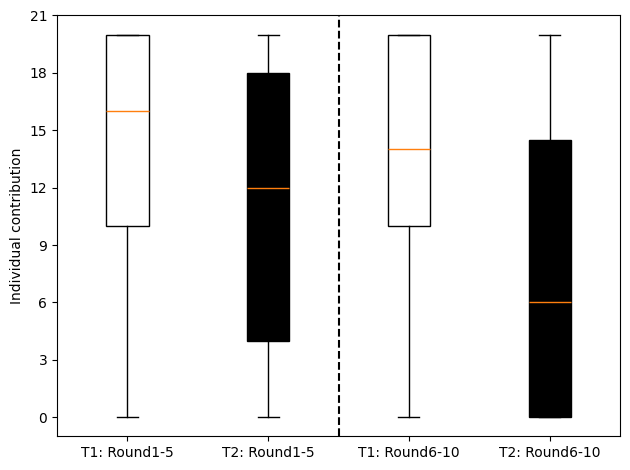

In [1]:
from getdata import *

# oTreeから得られた実験データ
g_normal = GetData(
    dirpath="./",
    filename="all_apps_wide-2025-07-24.csv"
)
g_info = GetData(
    dirpath="./",
    filename="all_apps_wide-2025-08-07.csv"
)

# グラフ描画用のインスタンス
gp = GraphPlot(g_normal, savefig=False, debug=True, figtype="png")
gp_info = GraphPlot(g_info, savefig=False, debug=True, figtype="png", color="black")

# gp.plot_pa_frequency()
# gp_info.plot_pa_frequency()
# gp.plot_pa_pledge()
# gp_info.plot_pa_pledge()
# gp.plot_target_pledge()
# gp_info.plot_target_pledge()
gp.plot_box(g_info)
gp.plot_box_round(g_info)